In [93]:
# Install:
# pandas, openpyxl, numpy, scikit-learn, matplotlib
# plotly, nbformat

In [737]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression

# Python academy
March 2023

In [95]:
df = pd.read_excel('podatki_python_akademija.xlsx')

In [96]:
df.columns

Index(['ID', 'DAN', 'LETO', 'DAN_V_TEDNU', 'TEDEN', 'DAN_V_MESECU', 'DATUM',
       'PRA_DAN', 'PRA_PRED', 'PRA_NASL', 'PRA', 'BDP1', 'BDP2', 'BDP3',
       'URA_VEC', 'URA_MANJ', 'MIN_VREDNOST', 'MAX_VREDNOST', 'STEVEC',
       'MIN_PRET_TED', 'MAX_PRET_TED', 'TEMP_MIN', 'TEMP_MAX', 'MIN_VRED_LM1',
       'MAX_VRED_LM1', 'PMIN_VRED_LM1', 'PMAX_VRED_LM1', 'RPMIN_VRED_LM1',
       'RPMAX_VRED_LM1'],
      dtype='object')

## Linear regression (3.-4.)

In [97]:
X = df["MAX_PRET_TED"].values.reshape(-1, 1)
Y = df["MAX_VREDNOST"].values # .reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

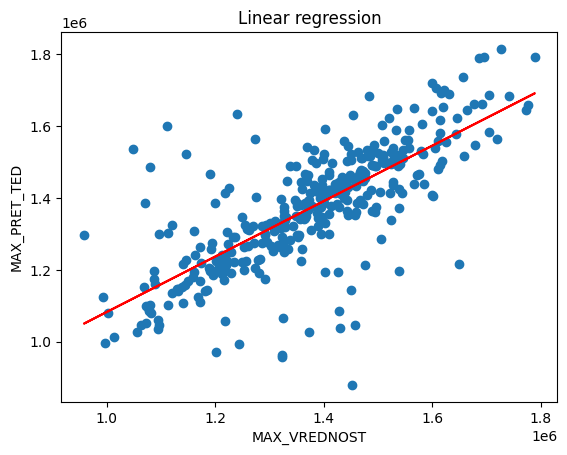

In [98]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title("Linear regression")
plt.xlabel("MAX_VREDNOST")
plt.ylabel("MAX_PRET_TED")
plt.show()

## Multiple linear regression (5.-6.)

In [99]:
X = df.drop(["ID", "DAN", "LETO", "DAN_V_TEDNU", "TEDEN", "DAN_V_MESECU", "DATUM", "STEVEC", "MIN_VREDNOST"], axis=1).values
Y = df["MAX_VREDNOST"].values
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

## BIC (7.)
Idea:
- Start by defining a set of candidate models. Each model in the set should include a different combination of predictor variables. For example, if you have 5 predictor variables, you could define a set of models that includes all possible combinations of those 5 variables (i.e., $2^5 - 1 = 31$ models).  
Our case: 20 vairables means $2^20 - 1 = 1048575$ models
- For each model in the set, estimate the multiple linear regression coefficients using your dataset.
- Compute the BIC value for each model using the following formula:  
$BIC = n * ln(RSS/n) + k * ln(n)$

This takes too much time, so we perform PCA instead and see, that 4 variables are more than sufficient for model explainability (98.46%).  
We then perform the idea above on up to 4 variable combinations.

In [101]:
# Prepare data
X = df.drop(["ID", "DAN", "LETO", "DAN_V_TEDNU", "TEDEN", "DAN_V_MESECU", "DATUM", "STEVEC", "MIN_VREDNOST", "MAX_VREDNOST"], axis=1)
Y = df["MAX_VREDNOST"]

In [308]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
rss = np.sum((Y - Y_pred)**2)
n = len(Y) # + 1.e-10
k = len(X) + 1 # add 1 for the intercept term
bic = n * np.log(rss/n) + k * np.log(n)
print(bic)
linear_regressor.coef_ # Coefficients for set of all variables

9974.455883906601


array([-2.79554164e+05, -7.75089144e+04, -3.12791412e+04,  4.11414921e+03,
        1.67620342e+02,  6.07611754e+03,  1.70860705e+04,  1.71737794e+05,
       -4.99170243e+03,  1.83749752e-01,  6.62245100e-02, -1.56068389e+03,
       -4.05792381e+03, -2.67684172e-02,  1.91102168e-01, -1.68302534e-01,
        7.94720916e-01, -1.42520297e-01, -4.35530139e-02])

In [305]:
from sklearn.decomposition import PCA
import plotly.express as px

# PCA
pca = PCA()
pca.fit(X)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [307]:
exp_var_cumul # explained variance by the number of components

array([0.82485661, 0.90210902, 0.95140523, 0.98460843, 0.99418678,
       0.9984509 , 0.99961983, 0.99999984, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [300]:
%%time
# Checks all possibilites for model parameters up to 4 variables
# Total combinations: 2^4 - 1 = 18
from itertools import combinations

# define candidate models
variables = X.columns
models = []
max_variables = 6 # Hardcode number of variables tested
for i in range(1, max_variables + 1):
    combos = combinations(variables, i)
    for combo in combos:
        models.append(list(combo))
        
bic_values = []
for model in models:
    X_subset = X[model]
    reg = LinearRegression().fit(X_subset, Y)
    rss = np.sum((Y - reg.predict(X_subset))**2)
    num_examples = len(Y) # + 1.e-10
    num_params = len(model) + 1 # add 1 for the intercept term
    bic = num_examples * np.log(rss/n) + num_params * np.log(n)
    bic_values.append(bic)

CPU times: user 1min 4s, sys: 221 ms, total: 1min 4s
Wall time: 1min 4s


In [301]:
best_model_idx = np.argmin(bic_values)
best_model = models[best_model_idx]
print(f"Best model (by BIC): {best_model} with BIC value {bic_values[best_model_idx]:.2f}")

Best model (by BIC): ['PRA_DAN', 'PRA_PRED', 'BDP1', 'MAX_PRET_TED', 'TEMP_MAX', 'PMAX_VRED_LM1'] with BIC value 7948.91


In [309]:
# Retrain linear regressor again with the best model to get coefficients
linear_regressor = LinearRegression()
linear_regressor.fit(X[best_model], Y)
Y_pred = linear_regressor.predict(X[best_model])
coefficients = np.round(linear_regressor.coef_, 3) # round coefficients

result_tuples = list(zip(best_model, coefficients)) # Zip coefficients with names
result_tuple = pd.DataFrame(result_tuples, columns=["variable", "coefficient"]).T
result_tuple.to_csv('out/Rezultat.csv', index=False, header=False) # Write result to CSV
result_tuple

,0,1,2,3,4,5
variable,PRA_DAN,PRA_PRED,BDP1,MAX_PRET_TED,TEMP_MAX,PMAX_VRED_LM1
coefficient,-284973.937,-76115.756,94.551,0.157,-4135.516,0.789


## 8. MAE, MAPE, SMAPE in RMSE

In [310]:
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(Y_pred - Y))
print("MAE:", mae)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y - Y_pred) / Y)) * 100
print("MAPE:", mape)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = np.mean(np.abs(Y - Y_pred) / ((np.abs(Y) + np.abs(Y_pred)) / 2)) * 100
print("SMAPE:", smape)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((Y_pred - Y)**2))
print("RMSE:", rmse)

MAE: 46654.440309214224
MAPE: 3.417058572992098
SMAPE: 3.422192296288244
RMSE: 60691.10564659926


## 9.-11. MAE, MAPE, SMAPE in RMSE function

In [464]:
def calculate_errors(df, col_measured: str, col_predicted: str):
    if df is None or not col_measured or not col_predicted:
        raise Exception("Provide correct input data (df, col_measured, col_predicted)!") 
    
    Y = df[col_measured]
    Y_pred = df[col_predicted]
    
    mae = round(np.mean(np.abs(Y_pred - Y)), 2)
    print("MAE:", mae)

    # Mean Absolute Percentage Error (MAPE)
    mape = round(np.mean(np.abs((Y - Y_pred) / Y)) * 100, 2)
    print("MAPE:", mape)

    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = round(np.mean(np.abs(Y - Y_pred) / ((np.abs(Y) + np.abs(Y_pred)) / 2)) * 100, 2)
    print("SMAPE:", smape)

    # Root Mean Squared Error (RMSE)
    rmse = round(np.sqrt(np.mean((Y_pred - Y)**2)), 2)
    print("RMSE:", rmse)
    
    return {"mae": mae, "mape": mape, "smape": smape, "rmse": rmse}

In [312]:
# preare data for calculate_errors function
Y_zipped = list(zip(Y, np.round(Y_pred, 2)))
Y_data = pd.DataFrame(Y_zipped, columns=["measured", "predicted"]) # create 2-column df from tuples

In [313]:
import json

errors = calculate_errors(Y_data, "measured", "predicted")

with open('out/Rezultat.csv', 'a') as f:
    f.write(json.dumps(errors))
    f.write("\n")

MAE: 46654.44
MAPE: 3.42
SMAPE: 3.42


## 12. Train - test (MLR - Multiple Linear Regression)
Not sure if i'm supposed to drop columns here or not, like before, since the instructions don't specify it explicitly. 

I figured I need to do so, since other data looks redundant + I can reuse the knowledge about the best (BIC) model from before.

In [635]:
# Split data on train and test set
X_train = df[df["DATUM"].dt.month < 12] # jan-nov
X_test = df[df["DATUM"].dt.month == 12] # december

Y_train = X_train["MAX_VREDNOST"]
Y_test = X_test["MAX_VREDNOST"]

# Get "best model" features from Rezultat.csv
best_feature_names = list(pd.read_csv("out/Rezultat.csv", nrows=0).columns)

X_train = X_train[best_feature_names]
X_test = X_test[best_feature_names]

In [637]:
# Train the models and predict on train and test data using MLR
linear_regressor = LinearRegression().fit(X_train, Y_train)
Y_pred = np.round(linear_regressor.predict(X_train), 2)
Y_test_pred = np.round(linear_regressor.predict(X_test), 2)

# Preare data for calculate_errors function
Y_train_data = pd.DataFrame(list(zip(Y_train, Y_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples
Y_test_data = pd.DataFrame(list(zip(Y_test, Y_test_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples

# Calculate errors
print("Train data errors:")
errors_train = calculate_errors(Y_train_data, "measured", "predicted")
print()
print("Test data errors:")
errors_test = calculate_errors(Y_test_data, "measured", "predicted")

# Write results to file
with open('out/NapakeUcnoTestno.csv', 'w') as f:
    f.write(json.dumps(errors_train))
    f.write("\n")
    f.write(json.dumps(errors_test))
    f.write("\n")

Train data errors:
MAE: 46454.52
MAPE: 3.4
SMAPE: 3.41
RMSE: 60460.74

Test data errors:
MAE: 48944.79
MAPE: 3.57
SMAPE: 3.52
RMSE: 64282.83


## 13. Train - test (SVM)

In [484]:
from sklearn.svm import SVR

# Train the models and predict on train and test data using SVM
svr = SVR(kernel="poly") # kernels: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
svr.fit(X_train, Y_train)
Y_pred = np.round(svr.predict(X_train), 2)
Y_test_pred = np.round(svr.predict(X_test), 2)

In [638]:
# Preare data for calculate_errors function
Y_train_data = pd.DataFrame(list(zip(Y_train, Y_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples
Y_test_data = pd.DataFrame(list(zip(Y_test, Y_test_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples

# Calculate errors
print("Train data errors:")
errors_train = calculate_errors(Y_train_data, "measured", "predicted")
print()
print("Test data errors:")
errors_test = calculate_errors(Y_test_data, "measured", "predicted")

# Write results to file
with open('out/SVM_napake.csv', 'w') as f:
    f.write(json.dumps(errors_train))
    f.write("\n")
    f.write(json.dumps(errors_test))
    f.write("\n")

Train data errors:
MAE: 46454.52
MAPE: 3.4
SMAPE: 3.41
RMSE: 60460.74

Test data errors:
MAE: 48944.79
MAPE: 3.57
SMAPE: 3.52
RMSE: 64282.83


### Linear
MAE: 424130.09
MAPE: 29.37
SMAPE: 36.88
RMSE: 513601.52

MAE: 647371.17
MAPE: 43.82
SMAPE: 58.21
RMSE: 700468.09

### Poly
MAE: 133087.74
MAPE: 10.27
SMAPE: 9.85
RMSE: 167738.97

MAE: 157593.53
MAPE: 11.0
SMAPE: 11.11
RMSE: 187562.12

### RBF
MAE: 133139.38
MAPE: 10.28
SMAPE: 9.86
RMSE: 167802.86

MAE: 157632.14
MAPE: 11.0
SMAPE: 11.11
RMSE: 187615.37

### Sigmoid
MAE: 133145.73
MAPE: 10.28
SMAPE: 9.86
RMSE: 167810.76

MAE: 157636.23
MAPE: 11.0
SMAPE: 11.11
RMSE: 187620.83

In [504]:
print("MLR Errors")
with open('out/NapakeUcnoTestno.csv') as f:
    data = f.read()
    print(data)

print("SVM Errors")
with open('out/SVM_napake.csv') as f:
    data = f.read()
    print(data)
    
# Better model is the one with lower error rates (my case: MLR model)

MLR Errors
{"mae": 46454.52, "mape": 3.4, "smape": 3.41, "rmse": 60460.74}
{"mae": 48944.79, "mape": 3.57, "smape": 3.52, "rmse": 64282.83}

SVM Errors
{"mae": 133087.74, "mape": 10.27, "smape": 9.85, "rmse": 167738.97}
{"mae": 157593.53, "mape": 11.0, "smape": 11.11, "rmse": 187562.12}



## 14. Moving train data window

In [641]:
# Start: 1.2. do 30.11
# Stop:  7.1. do 5.11

# JAN (lower limit train data)
jan_dates = df[df["DATUM"].dt.month == 1].sort_values("DATUM", ascending=False)
feb_01 = df[df["DATUM"].dt.month == 2].sort_values("DATUM").iloc[[0]] # Get first date in Feb (1.2.2012)
jan_dates = pd.concat([pd.DataFrame(feb_01), jan_dates], ignore_index=True) # Add first date in Feb on top

# NOV (upper limit train data)
nov_dates = df[df["DATUM"].dt.month == 11].sort_values("DATUM", ascending=False)

# DEC (Test data)
test_data = df[df["DATUM"].dt.month == 12]

In [778]:
def clean_df(df):
    # Removes unwanted columns
    unwanted_columns = ["ID", "DAN", "LETO", "DAN_V_TEDNU", "TEDEN", "DAN_V_MESECU", "DATUM", "STEVEC", "MIN_VREDNOST", "MAX_VREDNOST"]
    
    # Experiment part
    # Get "best model" features from Rezultat.csv, experiment with passing those to clean_df
    # best_feature_names = list(pd.read_csv("out/Rezultat.csv", nrows=0).columns)
    # X = df[best_feature_names]
    
    X = df.drop(unwanted_columns, axis=1)
    Y = df["MAX_VREDNOST"]
    return X, Y

In [779]:
train_mape_errors = []
test_mape_errors = []
dates = []

for i, (jan, nov) in enumerate(zip(jan_dates["DATUM"], nov_dates["DATUM"])):
    df_train = df[(df["DATUM"] >= jan) & (df["DATUM"] <= nov)] # get data between current jan and nov dates
    df_test = df[df["DATUM"].dt.month == 12]

    X_train, Y_train = clean_df(df_train)
    X_test, Y_test = clean_df(df_test)
    
    # Train model
    linear_regressor = LinearRegression().fit(X_train, Y_train)
    Y_pred = np.round(linear_regressor.predict(X_train), 2)
    Y_test_pred = np.round(linear_regressor.predict(X_test), 2)

    # Preare data for calculate_errors function
    Y_train_data = pd.DataFrame(list(zip(Y_train, Y_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples
    Y_test_data = pd.DataFrame(list(zip(Y_test, Y_test_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples

    # Calculate errors
    errors_train = calculate_errors(Y_train_data, "measured", "predicted")
    train_mape_errors.append(errors_train["mape"])
    errors_test = calculate_errors(Y_test_data, "measured", "predicted")
    test_mape_errors.append(errors_test["mape"])
    dates.append(f"{jan.strftime('%d.%m.')}-{nov.strftime('%d.%m.')}") # remember starting lower boundary of train data
    print()
    

MAE: 45394.45
MAPE: 3.36
SMAPE: 3.36
RMSE: 57681.8
MAE: 49441.08
MAPE: 3.52
SMAPE: 3.52
RMSE: 63331.53

MAE: 45552.09
MAPE: 3.37
SMAPE: 3.37
RMSE: 57742.85
MAE: 48392.07
MAPE: 3.45
SMAPE: 3.45
RMSE: 62512.94

MAE: 45566.37
MAPE: 3.37
SMAPE: 3.37
RMSE: 57709.05
MAE: 47908.0
MAPE: 3.42
SMAPE: 3.42
RMSE: 62198.09

MAE: 45448.54
MAPE: 3.36
SMAPE: 3.36
RMSE: 57632.45
MAE: 47478.23
MAPE: 3.4
SMAPE: 3.39
RMSE: 61956.88

MAE: 45471.0
MAPE: 3.36
SMAPE: 3.37
RMSE: 57713.8
MAE: 47389.77
MAPE: 3.39
SMAPE: 3.38
RMSE: 62050.18

MAE: 45446.48
MAPE: 3.36
SMAPE: 3.36
RMSE: 57719.11
MAE: 47229.42
MAPE: 3.38
SMAPE: 3.37
RMSE: 62077.24

MAE: 45333.75
MAPE: 3.35
SMAPE: 3.35
RMSE: 57673.12
MAE: 46795.95
MAPE: 3.35
SMAPE: 3.34
RMSE: 61907.98

MAE: 45228.0
MAPE: 3.34
SMAPE: 3.34
RMSE: 57621.9
MAE: 46346.42
MAPE: 3.33
SMAPE: 3.31
RMSE: 61714.94

MAE: 45168.67
MAPE: 3.33
SMAPE: 3.34
RMSE: 57580.5
MAE: 45983.02
MAPE: 3.3
SMAPE: 3.28
RMSE: 61576.09

MAE: 45152.09
MAPE: 3.33
SMAPE: 3.33
RMSE: 57591.07
MAE: 45545.0

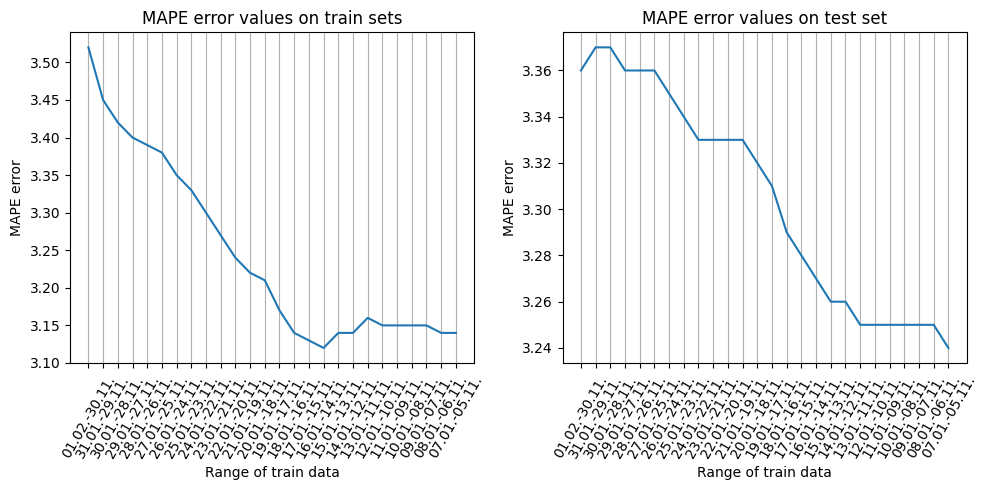

In [780]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(dates, test_mape_errors) # test_mape_errors, train_mape_errors
plt.xticks(dates)
plt.xticks(rotation=60)
plt.xlabel("Range of train data")
plt.ylabel("MAPE error")
plt.title("MAPE error values on train sets")
plt.grid(axis = 'x')

plt.subplot(1, 2, 2)
plt.plot(dates, train_mape_errors) # test_mape_errors, train_mape_errors
plt.xticks(dates)
plt.xticks(rotation=60)
plt.xlabel("Range of train data")
plt.ylabel("MAPE error")
plt.title("MAPE error values on test set")
plt.grid(axis = 'x')

plt.tight_layout()
plt.show()

## 15.-17. Read/write data
podatki_python_akademija.xlsx -> one_line_data.json -> one_line_data.json

In [813]:
df = pd.read_excel('podatki_python_akademija.xlsx')
df.to_json('out/one_line_data.json', orient='records', lines=False, date_format='iso') # Convert DataFrame to JSON and write to file
df_json = pd.read_json('out/one_line_data.json', orient='records', lines=False) # Read JSON file as DataFrame
df_json.to_csv('out/one_line_data.csv', index=False) # Convert DataFrame to CSV and write to file
df_csv = pd.read_csv('out/one_line_data.csv')
df_csv

,ID,DAN,LETO,DAN_V_TEDNU,TEDEN,DAN_V_MESECU,DATUM,PRA_DAN,PRA_PRED,PRA_NASL,...,MIN_PRET_TED,MAX_PRET_TED,TEMP_MIN,TEMP_MAX,MIN_VRED_LM1,MAX_VRED_LM1,PMIN_VRED_LM1,PMAX_VRED_LM1,RPMIN_VRED_LM1,RPMAX_VRED_LM1
0,4394,7,2012,6,1,7,2012-01-07T00:00:00.000,0,0,0,...,768580.1900,1356135.171,-3.54,6.96,918009.3016,1463812.453,878865.7527,1353361.412,881102.8285,1356806.275
1,4395,8,2012,7,1,8,2012-01-08T00:00:00.000,0,0,0,...,732239.0154,1097273.920,-3.06,7.98,806878.5555,1322471.904,789675.0528,1302986.299,791685.1015,1306302.937
2,4396,9,2012,1,2,9,2012-01-09T00:00:00.000,0,0,0,...,723862.6649,1239909.445,-3.18,9.12,856517.9152,1618444.884,859635.1201,1633467.730,861823.2461,1637625.579
3,4397,10,2012,2,2,10,2012-01-10T00:00:00.000,0,0,0,...,672229.4020,1358702.237,-2.58,9.30,848380.3675,1454486.136,864111.9607,1466199.363,866311.4820,1469931.445
4,4398,11,2012,3,2,11,2012-01-11T00:00:00.000,0,0,0,...,835758.4576,1443534.884,-3.60,8.68,884622.8336,1490064.426,902562.9037,1520159.840,904860.2986,1524029.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,4748,361,2012,3,52,26,2012-12-26T00:00:00.000,1,1,0,...,972021.2908,1649731.637,4.98,11.08,843604.6584,1417138.320,929715.3931,1567154.286,899949.9215,1516980.774
355,4749,362,2012,4,52,27,2012-12-27T00:00:00.000,0,1,0,...,859473.7260,1426951.755,0.92,7.62,723300.6745,1231897.682,805942.2192,1354883.329,780139.4301,1311505.816
356,4750,363,2012,5,52,28,2012-12-28T00:00:00.000,0,0,0,...,852669.1106,1402350.847,1.16,8.94,724241.1826,1201920.159,807486.4306,1332420.400,781634.2025,1289762.053
357,4751,364,2012,6,52,29,2012-12-29T00:00:00.000,0,0,0,...,808341.6088,1281482.418,-2.68,5.58,719521.8800,1269573.351,791176.4197,1270284.344,765846.3677,1229615.326


## 18.-19. Unittest
Uporabite, kar ste se naučili o unit testih, in primerjajte .csv iz 2. naloge z novo
nastalim .csv, ki ste ga pretvorili. Kreirajte uspešen unit test, ki bo uporabil obe
datoteki.  
Komentar: v 2. nalogi nimamo csv-ja ampak xlsx. Ugibam, da tu primerjamo enakost df-jev konstruiranih iz xlsx in csv datotek.

In [896]:
import unittest
import pandas as pd

class TestCsvFiles(unittest.TestCase):
    def test_csv_files(self):
        df_original = pd.read_excel("podatki_python_akademija.xlsx")
        df_created = pd.read_csv("out/one_line_data.csv", parse_dates=["DATUM"])
        
        self.assertEqual(pd.testing.assert_frame_equal(df_original, df_created), None)


if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)


test_csv_files (__main__.TestCsvFiles) ... ok
test_add (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.066s

OK
